In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ---------------- Dataset ----------------

class CocoDataset(Dataset):
    def __init__(self, root, ann_file):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = sorted(self.coco.imgs.keys())
        self.cat_ids = sorted(self.coco.cats.keys())
        self.cat_id_to_label = {cid: i + 1 for i, cid in enumerate(self.cat_ids)}
        self.label_to_name = ["__background__"] + [self.coco.cats[cid]["name"] for cid in self.cat_ids]
        self.transform = T.ToTensor()

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        img_name = self.coco.loadImgs(img_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, "images", img_name)).convert("RGB")

        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[ann["category_id"]])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id])
        }

        return self.transform(img), target

    def __len__(self):
        return len(self.ids)

def collate_fn(batch):
    return tuple(zip(*batch))

# ---------------- Paths ----------------

BASE = "/kaggle/input/brand-detection-dataset/Brand Detection Dataset"

train_ds = CocoDataset(f"{BASE}/train", f"{BASE}/train/_annotations.coco.json")
val_ds   = CocoDataset(f"{BASE}/valid", f"{BASE}/valid/_annotations.coco.json")
test_ds  = CocoDataset(f"{BASE}/test",  f"{BASE}/test/_annotations.coco.json")

# ---------------- Split + Class Print ----------------

print("\nDataset Summary")
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
print("Classes:", train_ds.label_to_name[1:])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Dataset Summary
Train: 300 | Val: 30 | Test: 14
Classes: ['Brands', 'Classmate', 'Colgate', 'Dettol', 'Himalaya', 'Kellogs']


In [3]:
# ---------------- Loaders ----------------

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# ---------------- Model ----------------

num_classes = len(train_ds.label_to_name)
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# ---------------- mAP Eval ----------------

def evaluate_map(model, dataset, loader):
    model.eval()
    coco_gt = dataset.coco
    coco_results = []

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for out, tgt in zip(outputs, targets):
                img_id = int(tgt["image_id"])
                for box, label, score in zip(out["boxes"], out["labels"], out["scores"]):
                    x1, y1, x2, y2 = box.tolist()
                    coco_results.append({
                        "image_id": img_id,
                        "category_id": dataset.cat_ids[label - 1],
                        "bbox": [x1, y1, x2 - x1, y2 - y1],
                        "score": score.item()
                    })

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.params.iouThrs = [0.5]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    per_class_ap = coco_eval.eval["precision"][0, :, :, 0, 2]
    per_class_ap = np.mean(per_class_ap, axis=0)

    return coco_eval.stats[0], per_class_ap

# ---------------- Training ----------------

num_epochs = 10
best_map = 0.0
map_history = []

print("\nStarting Training\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss = sum(model(images, targets).values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    map50, per_class_ap = evaluate_map(model, val_ds, val_loader)
    map_history.append(map50)

    print(f"[Epoch {epoch+1:02d}/{num_epochs}] Loss: {epoch_loss:.3f} | mAP@0.5: {map50:.4f}")

    if map50 > best_map:
        best_map = map50
        torch.save(model.state_dict(), "best_model.pth")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 230MB/s]



Starting Training

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.875
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.50 | ar

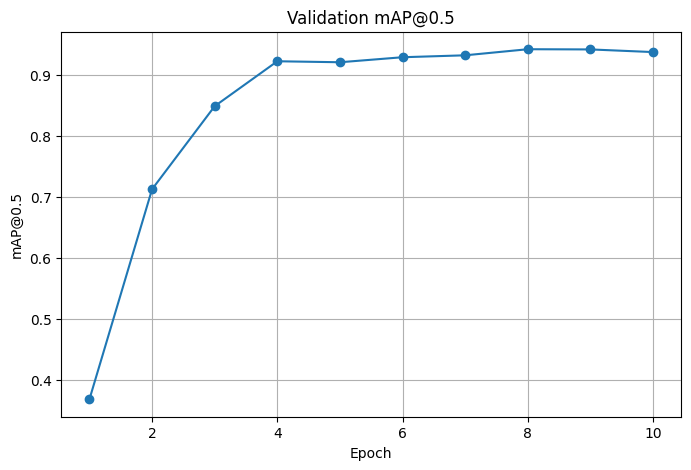


Final Per-class AP@0.5
Brands: -1.0000
Classmate: 0.8515
Colgate: 0.9285
Dettol: 0.9109
Himalaya: 0.9931
Kellogs: 1.0000


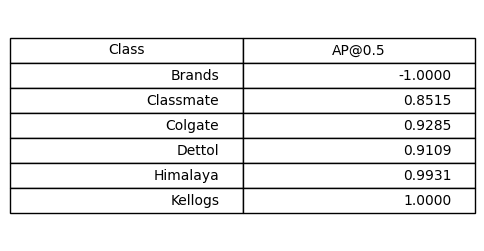

In [4]:
# ---------------- Plot ----------------

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), map_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.title("Validation mAP@0.5")
plt.grid(True)
plt.savefig("map_plot.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nFinal Per-class AP@0.5")
for name, ap in zip(train_ds.label_to_name[1:], per_class_ap):
    print(f"{name}: {ap:.4f}")

fig, ax = plt.subplots(figsize=(6,3))
ax.axis('off')

table_data = [[name, f"{ap:.4f}"] for name, ap in zip(train_ds.label_to_name[1:], per_class_ap)]
table = ax.table(cellText=table_data,
                 colLabels=["Class", "AP@0.5"],
                 loc='center')

table.scale(1, 1.5)
fig.savefig("per_class_ap.png", dpi=300, bbox_inches="tight")
plt.show()

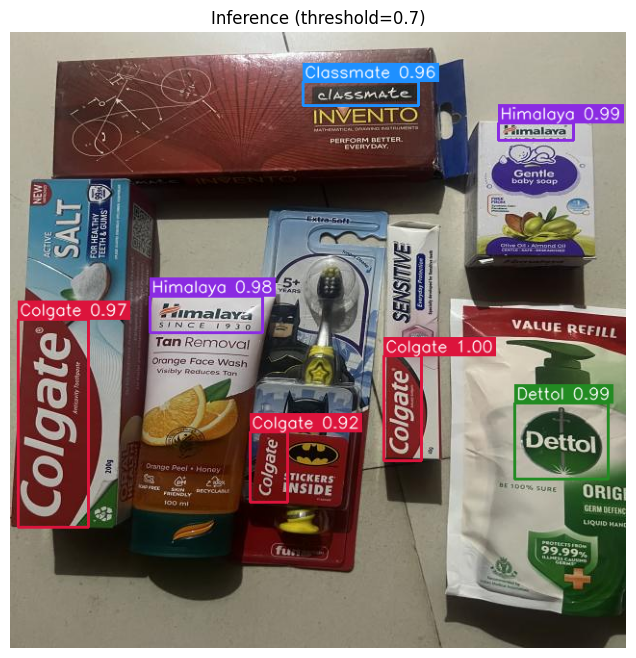


Detected Labels:
Classmate: 1
Colgate: 3
Dettol: 1
Himalaya: 2


In [5]:
# ---------------- Inference ----------------

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

img_path = f"{BASE}/test/images/IMG_4947_JPG.rf.ce74a181496a751ba4e47e59e7c228c4.jpg"

img = Image.open(img_path).convert("RGB")
img_tensor = T.ToTensor()(img).to(device)

with torch.no_grad():
    output = model([img_tensor])[0]

img_np = np.array(img)

# ---------------- Visualization ----------------

# Fixed palette
colors = {
    "Colgate": (220, 20, 60),
    "Dettol": (34, 139, 34),
    "Classmate": (30, 144, 255),
    "Kelloggs": (255, 140, 0),
    "Himalaya": (138, 43, 226)
}

threshold = 0.7
label_counts = {name: 0 for name in train_ds.label_to_name[1:]}

for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):

    if score.item() < threshold:
        continue

    # Convert tensors safely
    x1, y1, x2, y2 = map(int, box.cpu().numpy())
    name = train_ds.label_to_name[label.item()]
    color = colors[name]

    label_counts[name] += 1

    # Balanced bounding box
    cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)

    # YOLO-style label
    label_text = f"{name} {score.item():.2f}"
    (tw, th), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 1)

    # Background box
    cv2.rectangle(img_np, (x1, y1 - th - 6), (x1 + tw + 4, y1), color, -1)

    # White anti-aliased text
    cv2.putText(img_np, label_text, (x1 + 2, y1 - 4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255,255,255), 1, cv2.LINE_AA)

# ---------------- Display ----------------

plt.figure(figsize=(8,8))
plt.imshow(img_np)
plt.axis("off")
plt.title("Inference (threshold=0.7)")
plt.savefig("inference_result.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------- Detection Summary ----------------

print("\nDetected Labels:")
for k, v in label_counts.items():
    if v > 0:
        print(f"{k}: {v}")